In [1]:
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns
import mlflow
import joblib
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
def evaluate(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R2) Score: {r2}")

    return mse, rmse, r2

In [3]:
# Database connection parameters
db_params = {
    'host': 'host.docker.internal',
    'port': 5432,
    'database': 'airflow',
    'user': 'airflow',
    'password': 'airflow',
}

# Establish a connection to the database
connection = psycopg2.connect(**db_params)

# Create a cursor object
cursor = connection.cursor()

# Execute a sample query
cursor.execute("SELECT * FROM idealista_homes")
result = cursor.fetchall()

# Get the column names from the cursor description
column_names = [desc[0] for desc in cursor.description]

# Close the cursor and connection
cursor.close()
connection.close()

df = pd.DataFrame(data=result, columns=column_names)

In [4]:
df.head()

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,exterior,...,hasStaging,labels,topNewDevelopment,topPlus,superTopHighlight,neighborhood,highlight,newDevelopmentFinished,pagination,upload_date
0,102527865,https://img3.idealista.com/blur/WEB_LISTING/0/...,DF45-5F,21,5,1363.0,flat,rent,64.0,True,...,false,None,false,false,None,Nueva España,{'groupDescription': 'Destacado'},None,1,2024-01-25 09:29:52.102108
1,103589621,https://img3.idealista.com/blur/WEB_LISTING/0/...,PP-NSV26,14,1,1000.0,studio,rent,33.0,True,...,false,None,false,false,None,Tres Olivos - Valverde,None,None,1,2024-01-25 09:29:52.102108
2,103635464,https://img3.idealista.com/blur/WEB_LISTING/0/...,CH4,21,None,1000.0,chalet,rent,262.0,None,...,false,None,false,false,None,None,None,None,1,2024-01-25 09:29:52.102108
3,102548539,https://img3.idealista.com/blur/WEB_LISTING/0/...,None,11,9,1700.0,flat,rent,75.0,True,...,false,None,false,false,None,Nueva España,None,None,1,2024-01-25 09:29:52.102108
4,103280349,https://img3.idealista.com/blur/WEB_LISTING/0/...,AM2311086,41,3,2990.0,flat,rent,60.0,True,...,false,"[{'name': 'apartamentoType', 'text': 'Apartame...",false,false,None,Almagro,{'groupDescription': 'Destacado'},None,1,2024-01-25 09:29:52.102108


In [5]:
FEATURES = ["size", "rooms", "bathrooms", "numPhotos"]
TARGET = ["price"]
df = df[FEATURES + TARGET]

In [6]:
df.dtypes

size         float64
rooms          int64
bathrooms      int64
numPhotos      int64
price        float64
dtype: object

In [7]:
X, y = df[FEATURES], df[TARGET]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Number of training instances: {len(X_train)}")
print(f"Number of testing instances: {len(X_test)}")

# Create a linear regression pipeline with standard scaling
linear_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('linear_reg', LinearRegression())  # Linear Regression model
])

# Create a XGBoost pipeline with standard scaling
xgboost_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('linear_reg', XGBRegressor(n_estimators=1000))  # XGBoost model
])

print('---Linear Regression---')
# Fit the pipeline on the training data
linear_reg_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_reg_pipeline.predict(X_test)

mse, rmse, r2 = evaluate(y_test, y_pred)

print('---XGBoost---')
# Create a linear regression pipeline with standard scaling
xgboost_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = xgboost_pipeline.predict(X_test)

mse, rmse, r2 = evaluate(y_test, y_pred)

Number of training instances: 4811
Number of testing instances: 1203
---Linear Regression---
Mean Squared Error (MSE): 2152742.0974662434
Root Mean Squared Error (RMSE): 1467.2225793880912
R-squared (R2) Score: 0.5746150608967744
---XGBoost---
Mean Squared Error (MSE): 2687499.6906110705
Root Mean Squared Error (RMSE): 1639.3595367127587
R-squared (R2) Score: 0.46894619026771067


In [22]:
joblib.dump(xgboost_pipeline, "app/xgboost_pipeline.joblib")
joblib.dump(linear_reg_pipeline, "app/linear_regression.joblib")

['app/linear_regression.joblib']

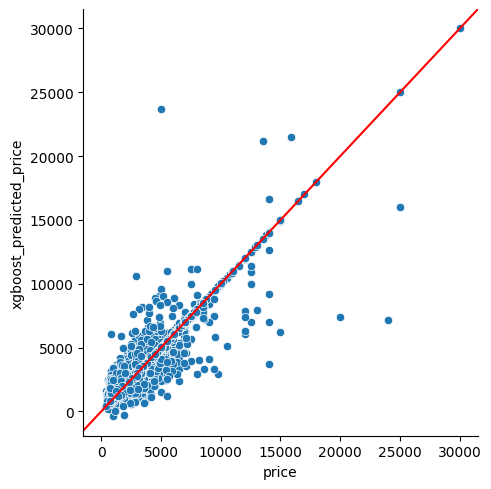

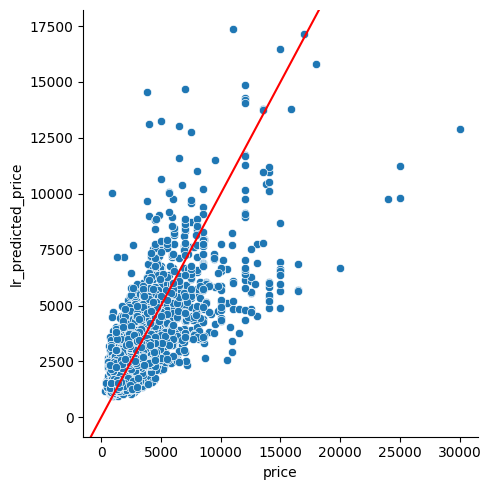

In [29]:
df['xgboost_predicted_price'] = xgboost_pipeline.predict(df[FEATURES])
df['lr_predicted_price'] = linear_reg_pipeline.predict(df[FEATURES])

# Plot actual vs predicted
g = sns.relplot(data=df[["price", "xgboost_predicted_price"]], x="price", y="xgboost_predicted_price", kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

g = sns.relplot(data=df[["price", "lr_predicted_price"]], x="price", y="lr_predicted_price", kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

In [20]:
# Set the MLflow tracking URI
mlflow.set_tracking_uri("http://host.docker.internal:5000/")

# Create a new MLflow Experiment
mlflow.set_experiment("Idealista Price Predictor")

# Start MLflow run
with mlflow.start_run(run_name = "test"):

    # Log the parameters used in the model
    mlflow.log_param("model_type", "linear_regression")

    # Log the metrics
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mse", rmse)
    mlflow.log_metric("mse", r2)
    mlflow.log_metric('train_size', len(X_train))
    mlflow.log_metric('test_size', len(X_test))

    # Log the trained model
    mlflow.sklearn.log_model(sk_model=xgboost_pipeline,
                             artifact_path="model")

MlflowException: API request to http://host.docker.internal:5000/api/2.0/mlflow-artifacts/artifacts/1/5a179e7e0eef42099ab28fc349ce0e75/artifacts/model/python_env.yaml failed with exception HTTPConnectionPool(host='host.docker.internal', port=5000): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/1/5a179e7e0eef42099ab28fc349ce0e75/artifacts/model/python_env.yaml (Caused by ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))